In [1]:
from lcls_tools.common.measurements.screen_beam_profile_measurement import ScreenBeamProfileMeasurement
from lcls_tools.common.data_analysis.projection_fit.projection_fit import ProjectionFit
from lcls_tools.common.data_analysis.projection_fit.gaussian_model import GaussianModel
from lcls_tools.common.image_processing.image_processing import ImageProcessor
from lcls_tools.common.image_processing.roi import ROI, RectangularROI, CircularROI
from lcls_tools.common.devices.device import Device, PVSet, ControlInformation, Metadata
from lcls_tools.common.devices.screen import ScreenControlInformation, ScreenPVSet, Screen
from matplotlib import pyplot as plt
from epics import PV, caget
import numpy as np
import h5py
import random

In [2]:
def read_file(fname):
    with h5py.File(fname) as f:
        images = f["images"][:]
    return images

In [3]:
path_to_h5py = '../../../../datasets/h5py/'
fname = path_to_h5py + 'test_image.h5'
images = read_file(fname)
image = images[0,:,:]

In [4]:
# creating projection fit class
gauss_model = GaussianModel()
projection_fit = ProjectionFit(model = gauss_model)

In [5]:
def get_projections(image):
    x_projection = np.array(np.sum(image,axis=0))
    y_projection = np.array(np.sum(image,axis=1))
    return x_projection, y_projection

In [6]:
xp , yp = get_projections(image)
xm = np.argmax(xp)
ym = np.argmax(yp)
# np.meshgrid (arange1,arange2)
#specifies center, calc

In [7]:
    def fill_value_outside_circle(img,center,radius,fill_value):
        height,width= img.shape
        for y in range(height):
            for x in range(width):
                distance =  np.sqrt((x - center[0])**2 + (y - center[1])**2)
                if distance > radius:
                    img[y, x] = fill_value
        return img

(200, 200)


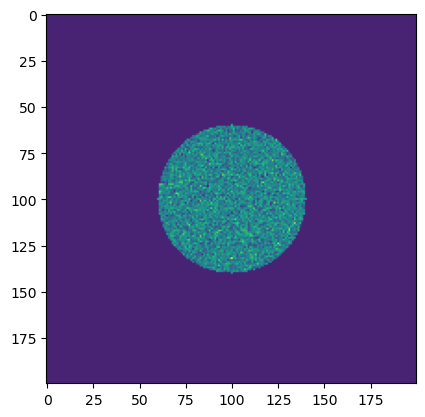

In [8]:
mean = [120,120]
size = [200,200]
cov = [[1600,0],[0,1600]]
square_shape =  np.random.multivariate_normal(mean = mean, cov = cov, size = size)
square_shape = square_shape[:,:,0]
print(square_shape.shape)

smaller_array = fill_value_outside_circle(img = square_shape,center = [100,100],radius=40,fill_value=0)
plt.imshow(smaller_array)
plt.show()
larger_array = np.zeros((800,800))
start_row = (larger_array.shape[0] - smaller_array.shape[0]) // 2
start_col = (larger_array.shape[1] - smaller_array.shape[1]) // 2
end_row = start_row + smaller_array.shape[0]
end_col = start_col + smaller_array.shape[1]
larger_array[start_row:end_row, start_col:end_col] = smaller_array

#problem is projection is going to make it hard to determine the mu value after sum

In [9]:
# creating image processing class
# would be nice to have default way of finding the center of image
# also maybe have rectangularROI have default roi_type 'Rectangular', and change roi_type to roi
roi = RectangularROI(roi_type='Rectangular',center =[400,400],xwidth=300,ywidth=300)
image_processor = ImageProcessor(roi = roi)

In [10]:

PVs = {
    'image': PV('OTRS:DIAG0:420:Image:ArrayData'),
    'n_bits': PV('OTRS:DIAG0:420:N_OF_BITS'),
    'n_col': PV('OTRS:DIAG0:420:Image:ArraySize1_RBV'),
    'n_row': PV('OTRS:DIAG0:420:Image:ArraySize0_RBV'),
    'resolution': PV('OTRS:DIAG0:420:RESOLUTION')
                        }
PV_strings = {
    'image': 'OTRS:DIAG0:420:Image:ArrayData',
    'n_bits': 'OTRS:DIAG0:420:N_OF_BITS',
    'n_col': 'OTRS:DIAG0:420:Image:ArraySize1_RBV',
    'n_row': 'OTRS:DIAG0:420:Image:ArraySize0_RBV',
    'resolution': 'OTRS:DIAG0:420:RESOLUTION'
}
metadata = {
        'area': 'DIAG0',
        'beam_path': ['SC_DIAG0'],
        'sum_l_meters': 56.813
        }
control_name =  "OTRS:DIAG0:420"

In [11]:
class ScreenTest(Screen):
    @property
    def image(self) -> np.ndarray:
        return self._image
    
    @image.setter
    def image(self,image):
        self._image = image

In [12]:
# creating Screen Device
# inconsistent use of Controls_information and control_information between classes recommend change.
screen_pvs = ScreenPVSet(**PV_strings)
meta_data = Metadata(**metadata)
controls_information = ScreenControlInformation(control_name = control_name, PVs = screen_pvs )
screen_test = ScreenTest(controls_information = controls_information, metadata = meta_data)


In [13]:
# can finally create screen beam profile measurement
screen_beam_profile_measurement = ScreenBeamProfileMeasurement(name = control_name,device = screen_test, image_processor = image_processor, fitting_tool = projection_fit)

In [14]:
# make img that is a circle in the center of the image with known standard dev and mean. no imports, no calls to external or
# internal files. 

In [15]:
test = ScreenBeamProfileMeasurement(name = control_name,device = screen_test, image_processor = image_processor, fitting_tool = projection_fit)
test.device.image = larger_array

processing image
processing image


{'raw_image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'processed_image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])}

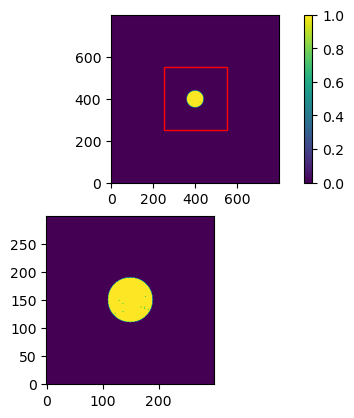

In [16]:
test.single_measure()

processing image
processing image
{'image_0': {'rms_x': {'amplitude': 10059.18887785509, 'mean': 150.6308035003761, 'sigma': 24.276261683888322, 'offset': 100.5918887785509}, 'rms_y': {'amplitude': 10363.975866112407, 'mean': 150.60331071898773, 'sigma': 23.779366103472597, 'offset': 103.63975866112408}}}


{}

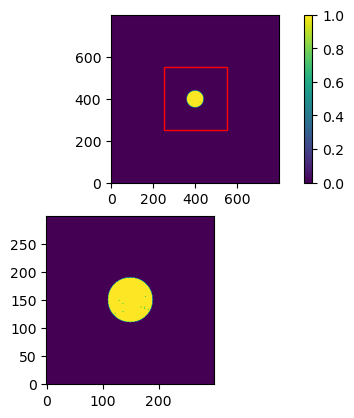

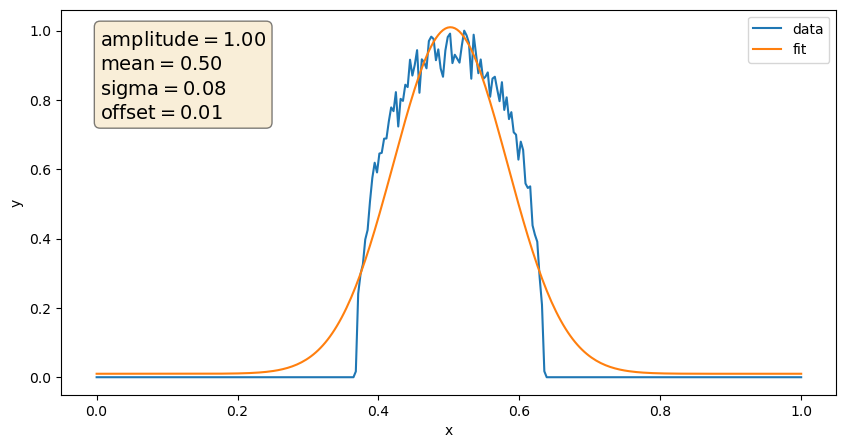

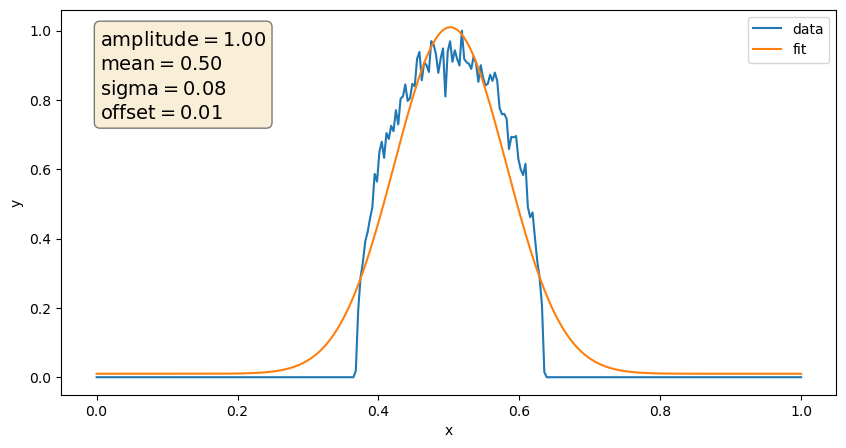

In [17]:
test.measure()